In [1]:
import h5py
import numpy      as np
import pandas     as pd
import matplotlib.pyplot as plt
import tensorflow as tf


In [2]:
with h5py.File('data.h5', 'r') as hf:
    X = hf['EEG_values'][:]             #Samples tensor
    y = hf['target_values'][:]          #Targets matrix

In [3]:
channels_order = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

In [4]:
from PCA_MTS import PCA_MTS

In [5]:
New_space = PCA_MTS(X)

Pls make sure that Input tensor X as shape of M: Samples , ni: length of time sereis , m: Numper of features 


In [6]:
eig_vals, eig_vecs , junk , junk = New_space.eigens()

In [7]:
Space = eig_vecs[:,0:12]

In [8]:
X_new     = np.dot(X,Space)

In [9]:
X_new.shape

(2444, 640, 12)

In [10]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 
# bad => ['/device:CPU:0']
# good output must be => ['/device:CPU:0', '/device:GPU:0']

['/device:CPU:0', '/device:GPU:0']


For validation, I gonna use the Leave one out approach as it's the most efficient approach also suits our samples.
<br>
<br>**How does it work? it simply means we'll select one of our subjects as a validation set and repeat the same algorithm for the other subjects so as I've 10 subjects, I'll train the model for 10 folds**

In [11]:
#Leave one out spliting
Subjects = 10
X_valid = ["X_valid" + str(i) for i in range (Subjects)]
X_train = ["X_train" + str(i) for i in range (Subjects)]
y_valid = ["y_valid" + str(i) for i in range (Subjects)]
y_train = ["y_train" + str(i) for i in range (Subjects)]

Mapping = { 0.00   : 0,
           12.00   : 1,
           10.00   : 2,
           8.57    : 3,
           7.50    : 4,
           6.66    : 5    }

for i in range(0 , y.shape[0]):
    Key  = float(str(y[i]))
    y[i] = Mapping[Key]
y = y.astype('int8')

exp_regions = np.where(y == 4)[0]
Subject_exp = 25

List_ = []
for i in range (0, exp_regions.shape[0]):
    if not(i%Subject_exp):
        List_.append(exp_regions[i])
List_.append(y.shape[0-1])

for Subject in range (Subjects):
    X_valid[Subject] = X_new[List_[Subject]:List_[Subject+1]]
    y_valid[Subject] = y[List_[Subject]:List_[Subject+1]]
    X_train[Subject] = np.delete(X_new, [*range(List_[Subject],List_[Subject+1])], 0)
    y_train[Subject] = np.delete(y, [*range(List_[Subject],List_[Subject+1])], 0)
    
X_train[0].shape

(2200, 640, 12)

In [12]:
No_Activity_Events = np.where(y_train[0]==0)[0]
len(No_Activity_Events)

1075

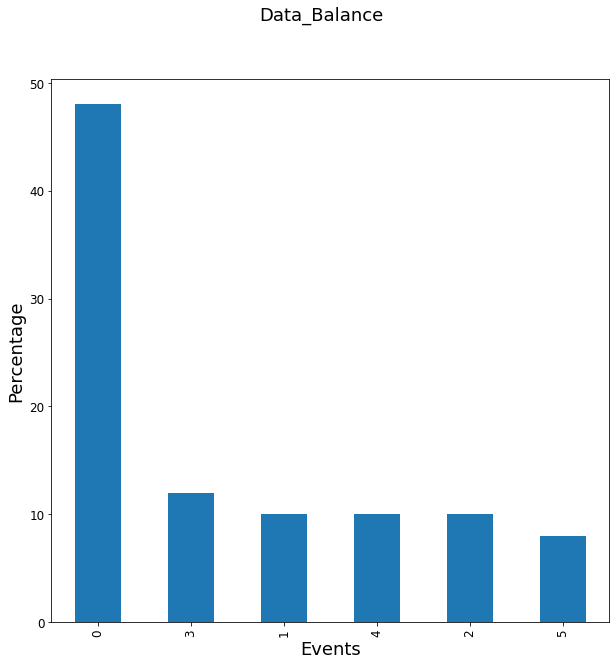

In [13]:
Events = pd.Series(y).to_frame().rename(columns={0: "Events"})['Events'].astype(str)
type_counts = Events.value_counts()
Coutns = type_counts.sum(axis = 0)
for i in range(len(type_counts)):
    type_counts.iloc[i] = int((type_counts.iloc[i]/Coutns)*100)
ax =type_counts.plot(kind='bar' , figsize =(10,10)  , fontsize = 12);
plt.suptitle('Data_Balance', fontsize=18);
plt.ylabel('Percentage', fontsize=18);
plt.xlabel('Events', fontsize=18);